In [1]:
import sys

import math

import torch
import gpytorch
from sklearn import preprocessing
from sklearn.utils import shuffle
import scipy
from scipy.special import logit, expit
from matplotlib import pyplot as plt

In [2]:
sys.path.insert(0, '/Users/Lorena/ML_IPAM/IPAM2021_ML/utils')
from utils import *

# Read, shuffle, standardize, and reshape data

In [3]:
xtrain = extractData('../../../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/train_recover.csv')
ytrain = extractData('../../../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/train_inject.csv')
xtest = extractData('../../../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/test_recover.csv')
ytest = extractData('../../../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/test_inject.csv')

In [4]:
xtrain = shuffle(xtrain, random_state=5)
ytrain = shuffle(ytrain, random_state=5)
xtest = shuffle(xtest, random_state=42)
ytest = shuffle(ytest, random_state=42)

Map data to range (0,1)

In [ ]:
min_val = 0.95
max_val = 2.4

A = np.array([[min_val, 1], [max_val, 1]])
B = np.array([0, 1])
X = np.linalg.solve(A,B)

a = X[0]
b = X[1]

y = lambda x : (a * x) + b

In [ ]:
ytrain_01 = y(ytrain)
xtrain_01 = y(xtrain)
ytest_01 = y(ytest)
xtest_01 = y(xtest)

In [ ]:
# Check mapping is correct:
print(np.min(xtrain_01), np.max(xtrain_01))
print(np.min(ytrain_01), np.max(ytrain_01))
print(np.min(xtest_01), np.max(xtest_01))
print(np.min(ytest_01), np.max(ytest_01))

Map data to range $(-\infty, \infty)$

In [ ]:
ytrain_inf = scipy.special.logit(ytrain_01)
xtrain_inf = scipy.special.logit(xtrain_01)
ytest_inf = scipy.special.logit(ytest_01)
xtest_inf = scipy.special.logit(xtest_01)

In [ ]:
# Check mapping is correct:
print(np.min(xtrain_inf), np.max(xtrain_inf))
print(np.min(ytrain_inf), np.max(ytrain_inf))
print(np.min(xtest_inf), np.max(xtest_inf))
print(np.min(ytest_inf), np.max(ytest_inf))

Standardize and reshape data to feed to training

In [ ]:
xtrain_scaler = preprocessing.StandardScaler().fit(xtrain_inf)
xtrain_scaled = xtrain_scaler.transform(xtrain_inf)
ytrain_scaler = preprocessing.StandardScaler().fit(ytrain_inf)
ytrain_scaled = ytrain_scaler.transform(ytrain_inf)

xtest_scaler = preprocessing.StandardScaler().fit(xtest_inf)
xtest_scaled = xtest_scaler.transform(xtest_inf)
ytest_scaler = preprocessing.StandardScaler().fit(ytest_inf)
ytest_scaled = ytest_scaler.transform(ytest_inf)

In [ ]:
train_x = torch.from_numpy(xtrain_scaled).float()
train_y = torch.from_numpy(ytrain_scaled).float()
test_x = torch.from_numpy(xtest_scaled).float()
test_y = torch.from_numpy(ytest_scaled).float()

train_x = train_x.unsqueeze(0).repeat(2, 1, 1)
train_y = train_y.transpose(-2, -1)

# Train and generate predictions

In [ ]:
%%time
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
        #self.covar_module.initialize_from_data(train_x, train_y)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
print('finding hyperparameters...')
model.train()
likelihood.train()

print('optimizing...')
# Use the adam optimizer
optimizer = torch.optim.Adam([
{'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y).sum()
    loss.backward()
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

In [ ]:
%%time
print('predicting...')
# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

Undo standardization, invert map $\phi^{-1}$ : $(-\infty,\infty) \rightarrow (0,1)$ and $\psi^{-1}$ : $(0,1) \rightarrow (0.95,2.4)$

In [ ]:
preds = torch.transpose(predictions.mean,0,1).numpy()
predicted_data_inf = ytest_scaler.inverse_transform(preds)

In [ ]:
predicted_data_01 = expit(predicted_data_inf)

In [ ]:
# Restrict to include min and max.
min_val = 0.95
max_val = 2.4

A = np.array([[min_val, 1], [max_val, 1]])
B = np.array([0, 1])
X = np.linalg.solve(A,B)

a = X[0]
b = X[1]

x = lambda y : (-b + y) * (1/a)
predicted_data = x(predicted_data_01)

In [ ]:
predicted_data

To save model and write data, run either cell below. Otherwise ignore.

In [ ]:
db = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'likelihood': likelihood.state_dict(), 'pred': predicted_data, 'mean': mean, 'lower': lower, 'upper': upper}
torch.save(db, '../data_files/RBF_default_tensors.pt')

In [ ]:
writeResult('../data_files/just_RBF.csv',predicted_data)

# Read predictions

In [ ]:
# If reading tensor data, run this
predicted_data = torch.load('../data_files/RBF_default_tensors.pt')['pred']

In [5]:
# If reading csv data, run this
predicted_data = extractData('../data_files/just_RBF.csv')

# Plotting

Define different types of errors for plotting

In [6]:
abs_rel_err = np.abs((ytest - predicted_data) /ytest)
rel_err = (ytest - predicted_data) /ytest
abs_pred_diff = np.abs(ytest - predicted_data)
pred_diff = ytest - predicted_data

rec_diff = ytest - xtest
rec_rel_err = (ytest - xtest)/ytest

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# A bad R2 score does not necessarily mean that our model is wrong.
print("R2 score : %.2f" % r2_score(ytest,predicted_data))
print("Mean squared error: %.2f" % mean_squared_error(ytest,predicted_data))

R2 score : 0.73
Mean squared error: 0.00


In [8]:
color_cycle = [
        (53/255.,  74/255.,  93/255.),   # black
        (59/255.,  153/255., 217/255.),  # blue
        (229/255., 126/255., 49/255.),   # orange
        (53/255.,  206/255., 116/255.),  # green
        (230/255., 78/255.,  67/255.),   # red
        (154/255., 91/255.,  179/255.),  # purple
        (240/255., 195/255., 48/255.),   # gold
        '#e377c2',                       # pink
        '#8c564b',                       # brown
        '#7f7f7f',                       # gray
        '#17becf',                       # teal
        '#bcbd22',                       # lime
    ]

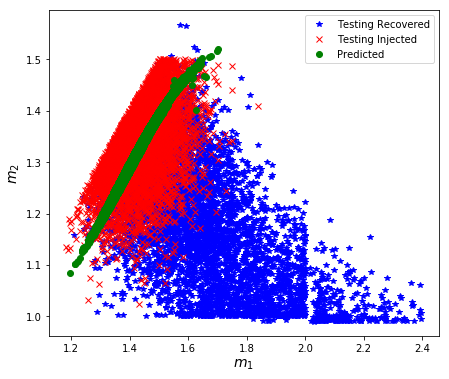

In [9]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(7, 6))

#Recovered
plt.plot(xtest[:,0], xtest[:,1], 'b*', label='Testing Recovered')

#Injected
plt.plot(ytest[:,0], ytest[:,1], 'rx', label='Testing Injected')

#Predicted
plt.plot(predicted_data[:,0], predicted_data[:,1], 'go', label='Predicted')       

plt.xlabel(r'$m_1$', fontsize=14)
plt.ylabel(r'$m_2$', fontsize=14)
plt.legend()
plt.show()

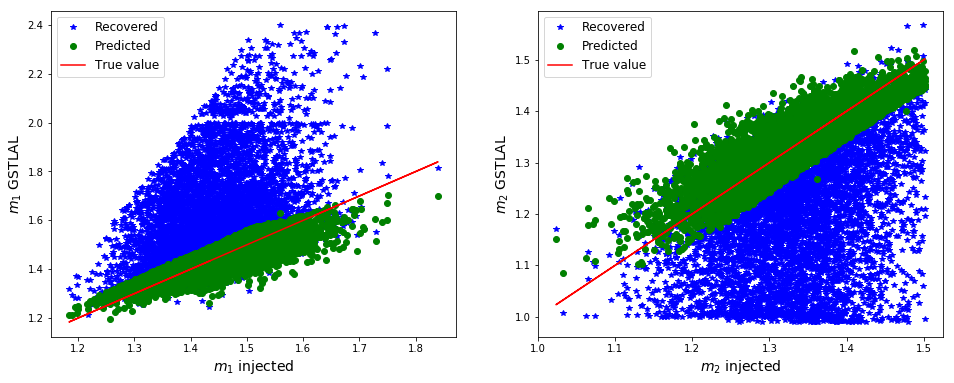

In [10]:
# Initialize plot
f, ax = plt.subplots(1, 2, figsize=(16, 6))

#Recovered
ax[0].plot(ytest[:,0], xtest[:,0], 'b*', label='Recovered')
ax[1].plot(ytest[:,1], xtest[:,1], 'b*', label='Recovered')

#Predicted
ax[0].plot(ytest[:,0], predicted_data[:,0], 'go', label='Predicted')       
ax[1].plot(ytest[:,1], predicted_data[:,1], 'go', label='Predicted') 

#True values
ax[0].plot(ytest[:,0], ytest[:,0], 'r-', label='True value')     
ax[1].plot(ytest[:,1], ytest[:,1], 'r-', label='True value') 

ax[0].set_xlabel(r'$m_1$ injected', fontsize=14)
ax[0].set_ylabel(r'$m_1$ GSTLAL', fontsize=14)
ax[0].legend(fontsize=12)

ax[1].set_xlabel(r'$m_2$ injected', fontsize=14)
ax[1].set_ylabel(r'$m_2$ GSTLAL', fontsize=14)
ax[1].legend(fontsize=12)
plt.show()

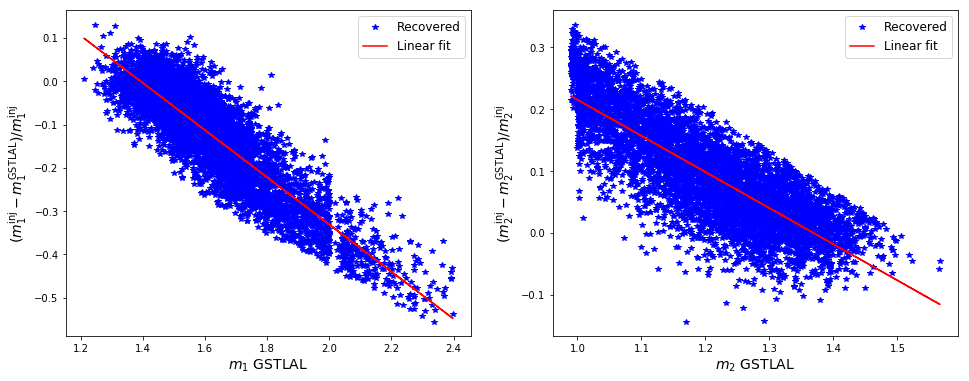

In [11]:
# Initialize plot
f, ax = plt.subplots(1, 2, figsize=(16, 6))

#Recovered
ax[0].plot(xtest[:,0], rec_rel_err[:,0], 'b*', label='Recovered')
ax[1].plot(xtest[:,1], rec_rel_err[:,1], 'b*', label='Recovered')

#Linear fit
z = np.polyfit(xtest[:,0], rec_rel_err[:,0], 1)
p = np.poly1d(z)
ax[0].plot(xtest[:,0], p(xtest[:,0]), 'r', label='Linear fit')

z = np.polyfit(xtest[:,1], rec_rel_err[:,1], 1)
p = np.poly1d(z)
ax[1].plot(xtest[:,1], p(xtest[:,1]), 'r', label='Linear fit')

ax[0].set_xlabel(r'$m_1$ GSTLAL', fontsize=14)
ax[0].set_ylabel(r'$(m_1^{\mathrm{inj}}-m_1^{\mathrm{GSTLAL}})/m_1^{\mathrm{inj}}$', fontsize=14)
ax[0].legend(fontsize=12)

ax[1].set_xlabel(r'$m_2$ GSTLAL', fontsize=14)
ax[1].set_ylabel(r'$(m_2^{\mathrm{inj}}-m_2^{\mathrm{GSTLAL}})/m_2^{\mathrm{inj}}$', fontsize=14)
ax[1].legend(fontsize=12)
plt.show()

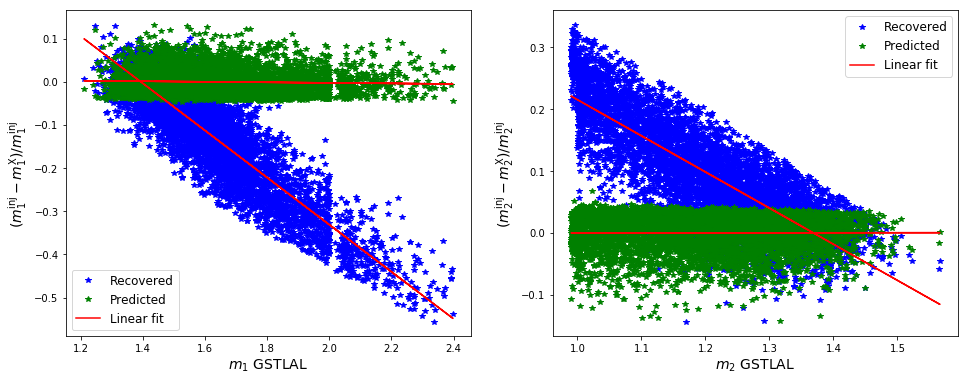

In [12]:
# Initialize plot
f, ax = plt.subplots(1, 2, figsize=(16, 6))

#Recovered
ax[0].plot(xtest[:,0], rec_rel_err[:,0], 'b*', label='Recovered')
ax[1].plot(xtest[:,1], rec_rel_err[:,1], 'b*', label='Recovered')

#Recovered
ax[0].plot(xtest[:,0], rel_err[:,0], 'g*', label='Predicted')
ax[1].plot(xtest[:,1], rel_err[:,1], 'g*', label='Predicted')

#Linear fit

z = np.polyfit(xtest[:,0], rec_rel_err[:,0], 1)
p = np.poly1d(z)
ax[0].plot(xtest[:,0], p(xtest[:,0]), 'r', label='Linear fit')

z = np.polyfit(xtest[:,0], rel_err[:,0], 1)
p = np.poly1d(z)
ax[0].plot(xtest[:,0], p(xtest[:,0]), 'r')

z = np.polyfit(xtest[:,1], rec_rel_err[:,1], 1)
p = np.poly1d(z)
ax[1].plot(xtest[:,1], p(xtest[:,1]), 'r', label='Linear fit')

z = np.polyfit(xtest[:,1], rel_err[:,1], 1)
p = np.poly1d(z)
ax[1].plot(xtest[:,1], p(xtest[:,1]), 'r')


ax[0].set_xlabel(r'$m_1$ GSTLAL', fontsize=14)
ax[0].set_ylabel(r'$(m_1^{\mathrm{inj}}-m_1^{\mathrm{X}})/m_1^{\mathrm{inj}}$', fontsize=14)
ax[0].legend(fontsize=12)

ax[1].set_xlabel(r'$m_2$ GSTLAL', fontsize=14)
ax[1].set_ylabel(r'$(m_2^{\mathrm{inj}}-m_2^{\mathrm{X}})/m_2^{\mathrm{inj}}$', fontsize=14)
ax[1].legend(fontsize=12)
plt.show()

The median is:  0.020659319906675373  and the mean is:  0.0232033446272664
The median is:  0.02050934931404714  and the mean is:  0.02312228011833264


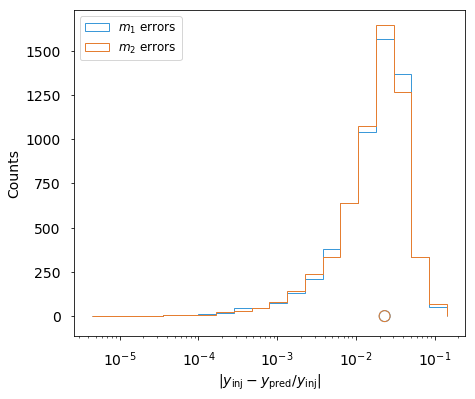

In [13]:
fig, axis = plt.subplots(1, figsize=(7,6))

combined_epsilons = [abs_rel_err[:,0], abs_rel_err[:,1]]

hist, bins, _ = axis.hist(combined_epsilons, 20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
axis.clear()

axis.set_xlabel(r'$|y_{\mathrm{inj}}-y_{\mathrm{pred}}/y_{\mathrm{inj}}|$', fontsize=14)
axis.set_ylabel(r'Counts', fontsize=14)
axis.tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ errors','$m_2$ errors']

color = ['blue', 'orange']
for i in range(len(combined_epsilons)):
    axis.hist(combined_epsilons[i], bins=logbins, histtype=u'step', label=labels[i], color=color_cycle[i+1], ls=styles[i])
    point = axis.scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color_cycle[i+1])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)

axis.set_xscale('log')
axis.legend(ncol = 1, loc="upper left", fontsize=12)
plt.show()

The median is:  -0.006150676348865937  and the mean is:  -0.00027424044972242264
The median is:  0.006623619134377744  and the mean is:  0.0002628536160239324


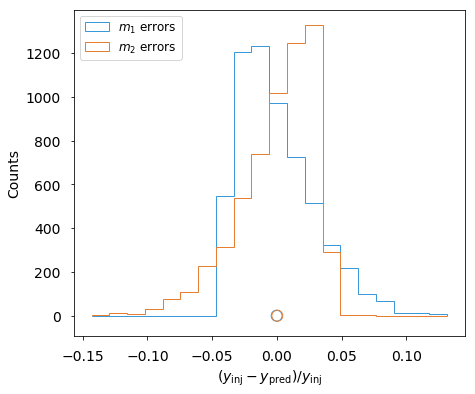

In [14]:
fig, axis = plt.subplots(1, figsize=(7,6))

combined_epsilons = [rel_err[:,0], rel_err[:,1]]

hist, bins, _ = axis.hist(combined_epsilons, 20)
axis.clear()

axis.set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis.set_ylabel(r'Counts', fontsize=14)
axis.tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ errors','$m_2$ errors']

color = ['blue', 'orange']
for i in range(len(combined_epsilons)):
    axis.hist(combined_epsilons[i], bins=bins, histtype=u'step', label=labels[i], color=color_cycle[i+1], ls=styles[i])
    point = axis.scatter(x=np.mean(combined_epsilons[i]), y=0, s=120, facecolors='none', edgecolors=color_cycle[i+1])
    print('The median is: ',np.median(combined_epsilons[i]), ' and the mean is: ',np.mean(combined_epsilons[i]))
    point.set_clip_on(False)

axis.legend(ncol = 1, loc="upper left", fontsize=12)
plt.show()

The median is:  -0.00027424044972242264  and the mean is:  -0.00027424044972242264
The median is:  -0.12361143315003566  and the mean is:  -0.12361143315003566
The median is:  0.006623619134377744  and the mean is:  0.0002628536160239324
The median is:  0.0827874731894478  and the mean is:  0.0959503710052032


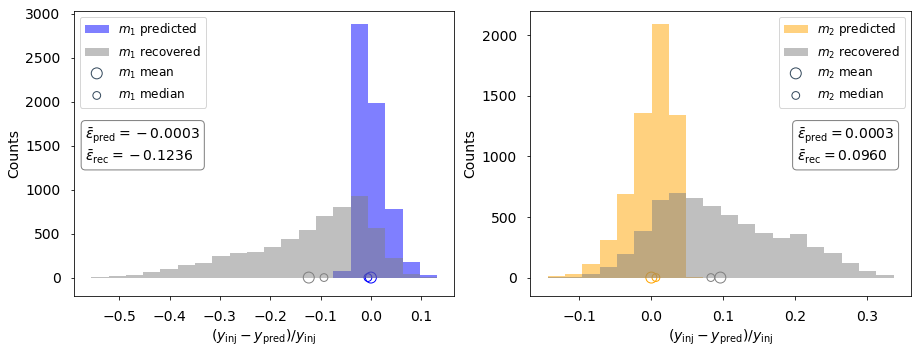

In [15]:
fig, axis = plt.subplots(1,2, figsize=(15,5.25))

combined_epsilons1 = [rel_err[:,0], rec_rel_err[:,0]]

hist, bins, _ = axis[0].hist(combined_epsilons1, 20)
axis[0].clear()
axis[0].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[0].set_ylabel(r'Counts', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_1$ predicted','$m_1$ recovered']

color = ['blue','gray']
for i in range(len(combined_epsilons1)):
    axis[0].hist(combined_epsilons1[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[0].scatter(x=np.mean(combined_epsilons1[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    points = axis[0].scatter(x=np.median(combined_epsilons1[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.mean(combined_epsilons1[i]), ' and the mean is: ',np.mean(combined_epsilons1[i]))
    point.set_clip_on(False)
    points.set_clip_on(False)

axis[0].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_1$ mean')
axis[0].scatter(x=[None],y=0, s=60, facecolors='none',color=color_cycle[0], label='$m_1$ median')

axis[0].legend(ncol = 1, loc="upper left", fontsize=12)

###################

combined_epsilons2 = [rel_err[:,1], rec_rel_err[:,1]]

hist, bins, _ = axis[1].hist(combined_epsilons2, 20)
axis[1].clear()
axis[1].set_xlabel(r'$\left(y_{\mathrm{inj}}-y_{\mathrm{pred}}\right)/y_{\mathrm{inj}}$', fontsize=14)
axis[1].set_ylabel(r'Counts', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=14, pad=10)
styles = ['-','-']
labels = ['$m_2$ predicted','$m_2$ recovered']


color = ['orange','gray']
for i in range(len(combined_epsilons2)):
    axis[1].hist(combined_epsilons2[i], bins=bins, label=labels[i], ls=styles[i],facecolor=color[i], alpha=0.5)
    point = axis[1].scatter(x=np.mean(combined_epsilons2[i]), y=0, s=120, facecolors='none', edgecolors=color[i])
    points = axis[1].scatter(x=np.median(combined_epsilons2[i]), y=0, s=60, facecolors='none', edgecolors=color[i])
    print('The median is: ',np.median(combined_epsilons2[i]), ' and the mean is: ',np.mean(combined_epsilons2[i]))
    point.set_clip_on(False)
    points.set_clip_on(False)
    
axis[1].scatter(x=[None],y=0, s=120, facecolors='none', color=color_cycle[0], label='$m_2$ mean')
axis[1].scatter(x=[None],y=0, s=60, facecolors='none',color=color_cycle[0], label='$m_2$ median')
    
axis[1].legend(ncol = 1, loc="upper right", fontsize=12)


textstr1 = '\n'.join((
    r'$\bar{\epsilon}_{\mathrm{pred}}=%.4f$' % (np.mean(combined_epsilons1[0]), ),
    r'$\bar{\epsilon}_{\mathrm{rec}}=%.4f$' % (np.mean(combined_epsilons1[1]), )))
textstr2 = '\n'.join((
    r'$\bar{\epsilon}_{\mathrm{pred}}=%.4f$' % (np.mean(combined_epsilons2[0]), ),
    r'$\bar{\epsilon}_{\mathrm{rec}}=%.4f$' % (np.mean(combined_epsilons2[1]), )))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

axis[0].text(0.03, 0.6, textstr1, transform=axis[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axis[1].text(0.7, 0.6, textstr2, transform=axis[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

outfile = '../figs/m1_m2_error_analysis_wboxes.pdf'
plt.savefig(outfile, bbox_inches="tight")
plt.show()